Simplex query for Peacocks.
Derived from matlab code: poly_query_peacock.mlx

In [86]:
import sys
!{sys.executable} -m pip install torch torchvision scipy matplotlib | grep -v 'already satisfied'

In [87]:
def clearvars():    
    for el in sorted(globals()):
        if '__' not in el:
                print(f'deleted: {el}')
                del el

In [88]:
# clearvars()

In [89]:
import pathlib
from simcoder.similarity import load_mf_encodings

allData = load_mf_encodings(pathlib.Path("/Volumes/Data/mf_resnet50/")) # load resnet 50 encodings

In [90]:

from scipy.io import loadmat
import numpy as np

def load_mf_softmax():
    basepath = pathlib.Path("/Volumes/Data/mf_softmax/")

    paths = basepath.glob("*.mat")
    paths = sorted(paths, key=lambda p: int(p.stem))
    encodings = [loadmat(p)["probVecs"] for p in paths]
    encodings = np.concatenate(encodings)
    return encodings

In [91]:
smData = load_mf_softmax()

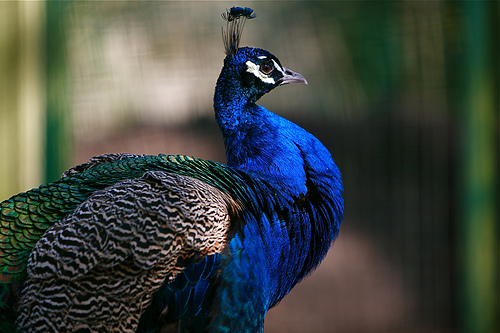

In [92]:
# Get the peacock at index 

from simcoder.similarity import get_mf_image

q0 = 101102 # a peacock

get_mf_image(q0)

In [93]:
from simcoder.similarity import euclid

def getDists(query_index,allData):
    '''Return the distances from the query to allData'''
    '''Returns an array same dimension as allData of scalars'''
    mf_query_data = allData[query_index]
    distances = euclid(mf_query_data, allData)
    return distances

In [94]:
from matplotlib import pyplot as plt

def imShow( image ):
    # plt.title(Image title")
    #plt.xlabel("X pixel scaling")
    # plt.ylabel("Y pixels scaling")

    fig = plt.figure(figsize = (1,1)) # in inches!
    plt.axis('off')
    plt.imshow(image) # figsize=(640/80,640/80), dpi=80)
    plt.show()

In [95]:
dists = getDists(q0,allData)
closest_indices = np.argsort(dists) # the closest images to the query
poly_query_indexes = closest_indices[0:6] # These are the indices we will use for the poly query
best_100_for_one = closest_indices[0:100]

In [96]:
# Load the sotmax encodings of the data

softmax_encodings = load_mf_softmax()


### TODO

[] This is new code - find the most peacocky peacocks.... These need added to the other files like this one

In [97]:
from simcoder.count_cats import getBestCats

peacock_category = 84

best_100_categorical = getBestCats(peacock_category,best_100_for_one,smData,allData)


In [98]:

print(dists[closest_indices[0:20]])
print(closest_indices[1]) # first index that is not the query

[ 0.       50.78749  50.92856  53.38101  53.9277   54.231636 55.64793
 56.531013 56.54724  57.075676 57.123547 57.132854 57.457184 57.576687
 58.038654 58.23291  58.41435  58.64924  58.70935  59.025887]
690003


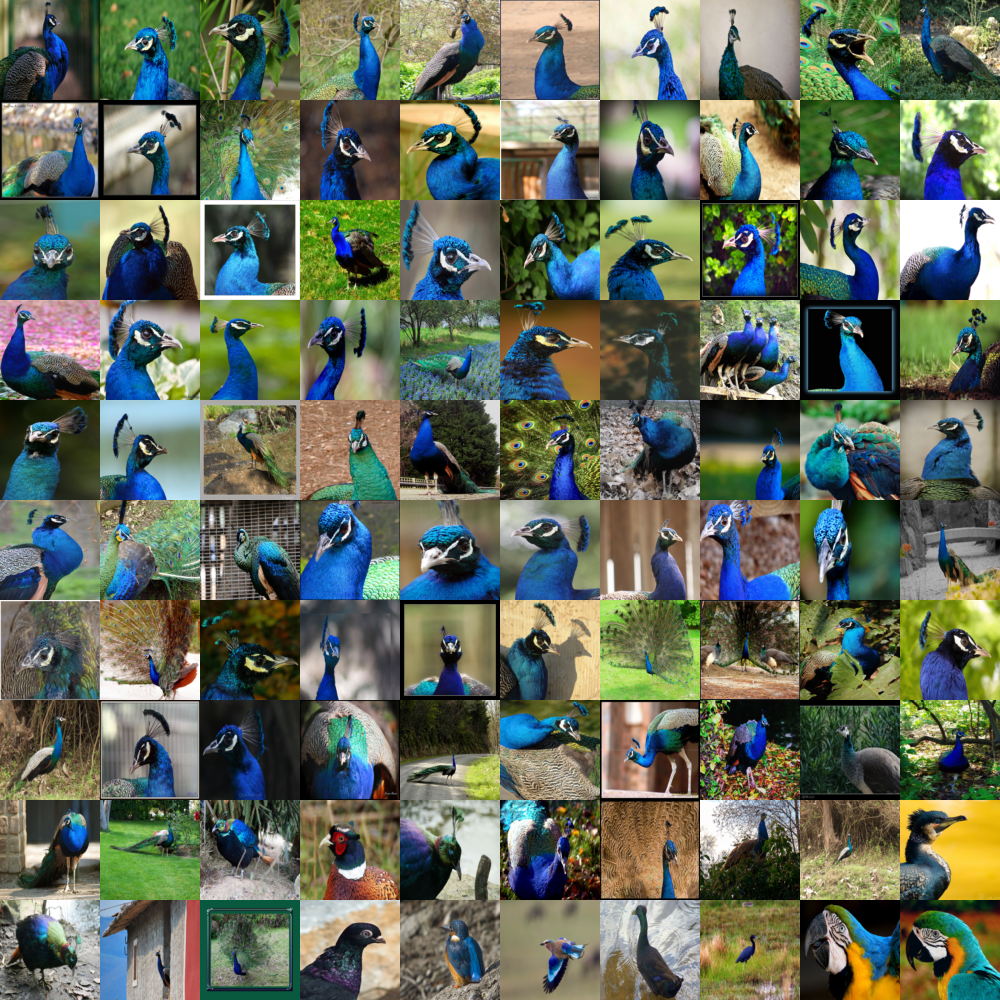

In [99]:
# These are the best images best on lowest average distance from the queries

from simcoder.similarity import make_mf_image_grid

make_mf_image_grid(best_100_categorical,10,10,100,100)

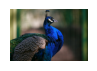

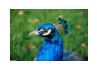

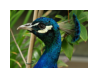

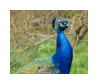

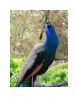

In [100]:


for i in range(0,5): # 0 is the original image
    imShow(get_mf_image(best_100_categorical[i]))

In [101]:

poly_query_indexes = best_100_categorical[0:5] # These are the indices we will use for the poly query

poly_query_data = allData[poly_query_indexes]

In [102]:
import math 

def euclid_scalar(p1: np.array, p2: np.array):
    distances = math.sqrt(np.sum((p1 - p2) ** 2))
    return distances

from simcoder.nsimplex import NSimplex
import numpy as np

def fromSimplexPoint(poly_query_distances : np.array, inter_pivot_distances : np.array, nn_dists:  np.array) -> np.array:
    '''poly_query_data is the set of reference points with which to build the simplex'''
    '''inter_pivot_distances are the inter-pivot distances with which to build the base simplex'''
    '''nn_dists is a column vec of distances, each abit more than the nn distance from each ref to the rest of the data set'''
    '''ie the "perfect" intersection to the rest of the set'''
    '''returns a np.array of distances between the perfect point and the rest of the data set'''

    nsimp = NSimplex()
    nsimp.build_base(inter_pivot_distances,False)

    # second param a (B,N)-shaped array containing distances to the N pivots for B objects.
    perfPoint = nsimp._get_apex(nsimp._base,nn_dists)    # was projectWithDistances in matlab

    for i in range(1000 * 1000):
        distvec = poly_query_distances[:,i];                      # a row vec of distances
        pr = nsimp._get_apex(nsimp._base,np.transpose(distvec));
        dists[i] = euclid_scalar(pr,perfPoint)

    return dists


In [103]:
# from Italian documentation: README.md line 25
from scipy.spatial.distance import pdist, squareform

inter_pivot_distances = squareform(pdist(poly_query_data, metric=euclid_scalar)) # pivot-pivot distance matrix with shape (n_pivots, n_pivots)

In [104]:
# Fetch the data and whole-set distances for the extra query objects
# fc6_poly_queries is the FC6 data for the queries we have chosen - not needed
# poly_query_distances is the distances from the queries to the all data 1000000,6

num_poly_queries = len(poly_query_indexes)

poly_query_distances = np.zeros((num_poly_queries,1000*1000))
for i in range(num_poly_queries):
    poly_query_distances[i] = getDists(poly_query_indexes[i],allData) 

print(num_poly_queries)
print(poly_query_data.shape)
print(poly_query_distances.shape)

5
(5, 1000)
(5, 1000000)


In [105]:
print(poly_query_indexes)
print(poly_query_distances.shape)
print(poly_query_distances)
print(inter_pivot_distances)

[101102 992909 865047 692655 664295]
(5, 1000000)
[[119.20433807 124.91448212 148.67747498 ... 113.59719086 112.48886871
  142.34590149]
 [104.42964172 115.13574219 136.78865051 ...  97.02158356 101.61142731
  124.44464111]
 [104.60696411 116.35757446 136.44171143 ... 100.66195679 105.95627594
  128.91662598]
 [ 90.57328033 108.5503006  135.4099884  ...  88.1197052   97.90415955
  124.39513397]
 [107.34609222 126.3894043  161.0599823  ... 115.39585114 114.18236542
  149.40197754]]
[[ 0.         63.3476253  60.4458512  63.20299173 62.5566384 ]
 [63.3476253   0.         50.81069819 58.58518062 77.98759166]
 [60.4458512  50.81069819  0.         53.67862494 79.15682368]
 [63.20299173 58.58518062 53.67862494  0.         68.81577819]
 [62.5566384  77.98759166 79.15682368 68.81577819  0.        ]]


### Simplex Projection

First calculate the distances from the queries to all data as we will be needing them again

In [106]:
nsimp = NSimplex()
nsimp.build_base(inter_pivot_distances,False)
# print(xx._base.shape)
# print(xx._base)
# print(inter_pivot_distances.shape)
# print(inter_pivot_distances)

In [107]:
# Next, find last coord from the simplex formed by 6 query points

all_apexes = nsimp._get_apex(nsimp._base,np.transpose(poly_query_distances))
altitudes = all_apexes[:,num_poly_queries -1] # the heights of the simplex - last coordinate



# altitudes = np.zeros(1000 * 1000) # 1D array to hold all the heights about the base simplex

# for i in range(1000 * 1000):
#     dists_from_i = poly_query_distances[:,i] # row of distances from queries to element i in dataset
#     apex = nsimp._get_apex(nsimp._base,np.transpose(dists_from_i))
#     # get Apex can do multiples at a time - not sure how to encode this!
#     altitudes[i] = apex[0,num_poly_queries -1] # last coordinate is the height of the apex


[ 0.          0.          0.          0.          0.         33.37329351
 34.96765994 36.60261869 36.60386087 37.24682855 37.77046882 37.87869597
 38.07249946 39.16349833 39.24452605 40.30146822 40.42576902 40.8951691
 41.24966442 41.26753573 41.41392649 41.45182867 41.56495038 41.71106307
 42.0482665  42.05360972 42.93852997 43.10715437 43.48362677 44.19847551
 44.24221323 44.51575709 45.07286484 45.11270926 45.15781811 45.20726201
 46.34364516 46.67168989 46.82777228 46.95960596 46.96317287 47.36668865
 47.49408037 47.52295851 47.56400357 47.7443359  47.86979574 48.14896531
 48.22765747 48.40740706 48.4927879  48.52295563 48.74848328 48.75065946
 48.78112233 48.93789634 49.00669073 49.01455668 49.31671397 49.38366155
 49.48743157 49.73451233 49.74540278 50.43046611 50.62923278 50.64961186
 50.72750958 50.77451218 51.03293097 51.03525488 51.23655175 51.35266057
 51.76436337 51.99615246 52.46699878 52.58655362 52.85072938 52.95025212
 53.02869671 53.08196851 53.19346674 53.57540717 53.

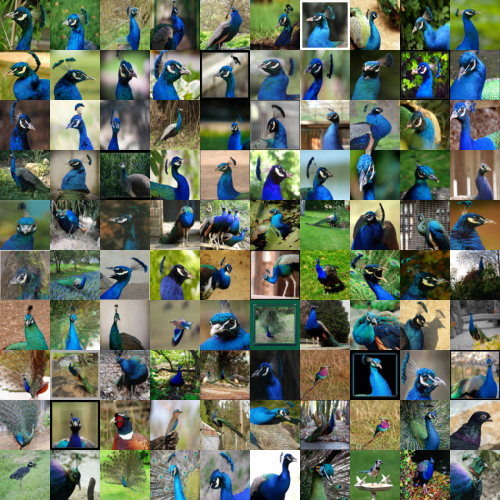

In [108]:
closest_indices = np.argsort(altitudes) # the closest images to the perfect point
print( altitudes[closest_indices][:100] )

best_100_for_simplex = closest_indices[0:100]

make_mf_image_grid(best_100_for_simplex,10,10,50,50)

In [109]:
# Now want to report results the total count in the category

from simcoder.count_cats import countNumberinCatGTThresh 
from simcoder.count_cats import countNumberInResultsInCat

encodings_for_best_100_single = softmax_encodings[best_100_for_one] # the alexnet encodings for the best 100 average singlequery images
single_peacock_totals = encodings_for_best_100_single[:,peacock_category]
print("Total peacock sum for single query best 100: ", np.sum(single_peacock_totals))


encodings_for_best_100_average = softmax_encodings[best_100_for_simplex] # the alexnet encodings for the best 100 polyquery images
average_peacock_totals = encodings_for_best_100_average[:,peacock_category]
print("Total peacock sum for poly query best 100: ", np.sum(average_peacock_totals))

res = countNumberInResultsInCat(peacock_category,0.9,best_100_for_one,softmax_encodings)
print("Total with thresh better than 0.9 single query : ", res)

res = countNumberInResultsInCat(peacock_category,0.9,best_100_for_simplex,softmax_encodings)
print("Total with thresh better than 0.9 poly query : ", res)

Total peacock sum for single query best 100:  84.09667855453304
Total peacock sum for poly query best 100:  89.02192878986898
Total with thresh better than 0.9 single query :  77
Total with thresh better than 0.9 poly query :  82
